# 🎯 Layer Pair Visualization - Ricci Flow Analysis

This notebook creates **layer pair visualization** scatter plots showing the relationship between:
- **Total Geodesic Change** (Δg_l = g_l - g_{l-1})
- **Total Curvature** (Forman-Ricci curvature Ric_{l-1})

Based on the paper: *"Deep Learning as Ricci Flow"* (Baptista et al., 2024)

## Data Sources
The notebook reads from `msc.csv` (geodesic changes) and `mfr.csv` (Ricci curvatures) files in the `output_layers/` directory.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap
import os
from pathlib import Path
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Base directory
BASE_DIR = Path.cwd()
OUTPUT_LAYERS_DIR = BASE_DIR / 'output_layers'
VISUALS_DIR = BASE_DIR / 'visuals'

# Create visuals directory if it doesn't exist
VISUALS_DIR.mkdir(exist_ok=True)

print(f"📁 Base Directory: {BASE_DIR}")
print(f"📊 Output Layers: {OUTPUT_LAYERS_DIR}")
print(f"🎨 Visuals Output: {VISUALS_DIR}")

📁 Base Directory: /Users/cihan/Documents/GitHub/Ricci-Flow-Deep-Learning---Graduation-Project
📊 Output Layers: /Users/cihan/Documents/GitHub/Ricci-Flow-Deep-Learning---Graduation-Project/output_layers
🎨 Visuals Output: /Users/cihan/Documents/GitHub/Ricci-Flow-Deep-Learning---Graduation-Project/visuals


## 📚 Available Configurations

Let's discover all available architecture + dataset + k-value combinations.

In [3]:
def discover_configurations():
    """
    Discover all available configurations from output_layers directory.
    Returns a DataFrame with architecture, dataset, k-value, and paths.
    """
    configurations = []
    
    for combo_dir in OUTPUT_LAYERS_DIR.iterdir():
        if not combo_dir.is_dir() or combo_dir.name.startswith('.'):
            continue
        
        # Parse architecture and dataset from directory name
        name = combo_dir.name
        
        # Find analysis_k* directories
        for analysis_dir in combo_dir.iterdir():
            if analysis_dir.is_dir() and analysis_dir.name.startswith('analysis_k'):
                k_value = int(analysis_dir.name.replace('analysis_k', ''))
                
                msc_path = analysis_dir / 'msc.csv'
                mfr_path = analysis_dir / 'mfr.csv'
                
                if msc_path.exists() and mfr_path.exists():
                    # Parse architecture type and depth
                    parts = name.split('_')
                    if len(parts) >= 2:
                        arch_type = parts[0]  # narrow, wide, bottleneck
                        depth = int(parts[1]) if parts[1].isdigit() else 0
                        dataset = '_'.join(parts[2:])  # rest is dataset
                        
                        configurations.append({
                            'architecture': arch_type,
                            'depth': depth,
                            'dataset': dataset,
                            'k': k_value,
                            'combo_name': name,
                            'msc_path': str(msc_path),
                            'mfr_path': str(mfr_path),
                            'analysis_dir': str(analysis_dir)
                        })
    
    return pd.DataFrame(configurations)

# Discover all configurations
configs_df = discover_configurations()
print(f"✅ Found {len(configs_df)} configurations")
print(f"\n📐 Architectures: {configs_df['architecture'].unique().tolist()}")
print(f"📊 Depths: {sorted(configs_df['depth'].unique().tolist())}")
print(f"📁 Datasets: {configs_df['dataset'].unique().tolist()}")
print(f"🔢 k-values: {sorted(configs_df['k'].unique().tolist())}")

# Show sample
display(configs_df.head(10))

✅ Found 239 configurations

📐 Architectures: ['narrow', 'wide', 'bottleneck']
📊 Depths: [5, 11]
📁 Datasets: ['mnist_6_vs_8', 'mnist_1_vs_7', 'fmnist_sandals_vs_boots', 'fmnist_shirts_vs_coats', 'synthetic_b', 'synthetic_c', 'synthetic_a', 'synthetic_C_b70']
🔢 k-values: [6, 7, 9, 10, 15, 18, 20, 30, 50, 90, 100, 325, 400, 500]


,architecture,depth,dataset,k,combo_name,msc_path,mfr_path,analysis_dir
0,narrow,11,mnist_6_vs_8,400,narrow_11_mnist_6_vs_8,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...
1,narrow,11,mnist_6_vs_8,325,narrow_11_mnist_6_vs_8,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...
2,narrow,11,mnist_6_vs_8,500,narrow_11_mnist_6_vs_8,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...
3,wide,5,mnist_1_vs_7,400,wide_5_mnist_1_vs_7,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...
4,wide,5,mnist_1_vs_7,325,wide_5_mnist_1_vs_7,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...
5,wide,5,mnist_1_vs_7,500,wide_5_mnist_1_vs_7,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...
6,bottleneck,5,fmnist_sandals_vs_boots,400,bottleneck_5_fmnist_sandals_vs_boots,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...
7,bottleneck,5,fmnist_sandals_vs_boots,325,bottleneck_5_fmnist_sandals_vs_boots,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...
8,bottleneck,5,fmnist_sandals_vs_boots,500,bottleneck_5_fmnist_sandals_vs_boots,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...
9,wide,11,fmnist_shirts_vs_coats,400,wide_11_fmnist_shirts_vs_coats,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...,/Users/cihan/Documents/GitHub/Ricci-Flow-Deep-...


## 🎨 Layer Pair Visualization Function

This function creates beautiful scatter plots matching the style of the existing visualizations.

In [4]:
def create_layer_pair_visualization(msc_path, mfr_path, title=None, output_path=None, show_plot=True):
    """
    Create a scatter plot of total curvature vs total geodesic change,
    with one point per layer pair, matching the style of existing visualizations.
    
    Parameters:
    -----------
    msc_path : str
        Path to msc.csv (geodesic changes)
    mfr_path : str
        Path to mfr.csv (Ricci curvatures)
    title : str, optional
        Custom title for the plot
    output_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    
    Returns:
    --------
    dict : Contains correlation values and plot metadata
    """
    
    # Read the CSV files
    msc = pd.read_csv(msc_path)
    mfr = pd.read_csv(mfr_path)
    
    # Align mfr with msc: msc layer l corresponds to mfr layer l-1
    mfr_shifted = mfr.copy()
    mfr_shifted['layer'] = mfr_shifted['layer'] + 1
    
    # Merge the dataframes
    merged = msc.merge(mfr_shifted, on=['mod', 'layer'], suffixes=('_dg', '_fr'))
    
    # Calculate r_all correlation (on ALL individual data points)
    r_all, p_all = pearsonr(merged["ssr_dg"].values, merged["ssr_fr"].values)
    
    # Filter out layer 1 for visualization (since it doesn't have a proper layer pair)
    merged_vis = merged[merged['layer'] != 1]
    
    # Aggregate per layer pair: sum across all models for each layer
    # This gives one point per layer pair for visualization
    aggregated = merged_vis.groupby('layer').agg({
        'ssr_dg': 'sum',  # Total geodesic change
        'ssr_fr': 'sum'   # Total curvature
    }).reset_index()
    
    # Sort by layer
    aggregated = aggregated.sort_values('layer')
    
    # Calculate Pearson correlation on aggregated data (paper's methodology)
    if len(aggregated) >= 2:
        correlation_aggregated, p_value_aggregated = pearsonr(
            aggregated['ssr_dg'], aggregated['ssr_fr']
        )
    else:
        correlation_aggregated, p_value_aggregated = np.nan, np.nan
    
    correlation = correlation_aggregated
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define colors from light yellow to dark blue (matching existing plots)
    colors_list = [
        '#FFFFE0', '#FFFF99', '#FFFF00', '#CCFF00', '#99FF00', 
        '#66FF00', '#33FF00', '#00CCFF', '#0099FF', '#0066FF', '#0033FF'
    ]
    
    # Map each layer to a color index
    n_layers = len(aggregated)
    layer_colors = {}
    for idx, layer in enumerate(sorted(aggregated['layer'].unique())):
        color_idx = int((idx / max(n_layers - 1, 1)) * (len(colors_list) - 1))
        layer_colors[int(layer)] = colors_list[color_idx]
    
    # Scatter plot with color coding by layer pair
    legend_elements = []
    for _, row in aggregated.iterrows():
        layer = int(row['layer'])
        color = layer_colors[layer]
        ax.scatter(
            row['ssr_dg'], row['ssr_fr'], 
            c=color, 
            s=200, 
            edgecolors='black',
            linewidth=1.5,
            alpha=0.9,
            zorder=3
        )
        legend_elements.append(
            plt.Line2D(
                [0], [0], marker='o', color='w', 
                markerfacecolor=color, 
                markersize=12, 
                markeredgecolor='black',
                markeredgewidth=1.5,
                label=f'layer {layer}-layer {layer-1}'
            )
        )
    
    # Add regression line
    if len(aggregated) >= 2:
        z = np.polyfit(aggregated['ssr_dg'], aggregated['ssr_fr'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(aggregated['ssr_dg'].min(), aggregated['ssr_dg'].max(), 100)
        ax.plot(x_line, p(x_line), 'k-', linewidth=2.5, alpha=0.9, zorder=2)
    
    # Add correlation coefficient text (using rho symbol)
    ax.text(
        0.95, 0.95, f'ρ = {correlation:.2f}', 
        transform=ax.transAxes, 
        fontsize=16, 
        verticalalignment='top',
        horizontalalignment='right',
        fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black')
    )
    
    # Labels
    ax.set_xlabel('total geodesic change', fontsize=14, fontweight='bold')
    ax.set_ylabel('total curvature', fontsize=14, fontweight='bold')
    
    # Title
    if title:
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Format axes with scientific notation
    ax.ticklabel_format(style='scientific', axis='both', scilimits=(0,0), useMathText=True)
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Grid for better readability
    ax.grid(True, alpha=0.3, linestyle='--', zorder=1)
    
    # Create legend on the right side
    ax.legend(
        handles=legend_elements, 
        loc='center left', 
        bbox_to_anchor=(1.02, 0.5), 
        fontsize=10, 
        framealpha=0.9
    )
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {output_path}")
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    return {
        'correlation_aggregated': correlation_aggregated,
        'p_value_aggregated': p_value_aggregated,
        'r_all': r_all,
        'p_all': p_all,
        'n_layer_pairs': len(aggregated),
        'n_models': len(merged['mod'].unique())
    }

print("✅ Visualization function defined!")

✅ Visualization function defined!


## 🔬 Generate Specific Visualizations

Now let's generate the same plots as the reference images.


📊 bottleneck 5 fmnist sandalsVboots k400
✅ Saved: /Users/cihan/Documents/GitHub/Ricci-Flow-Deep-Learning---Graduation-Project/visuals/bottleneck 5 fmnist sandalsVboots k400.png


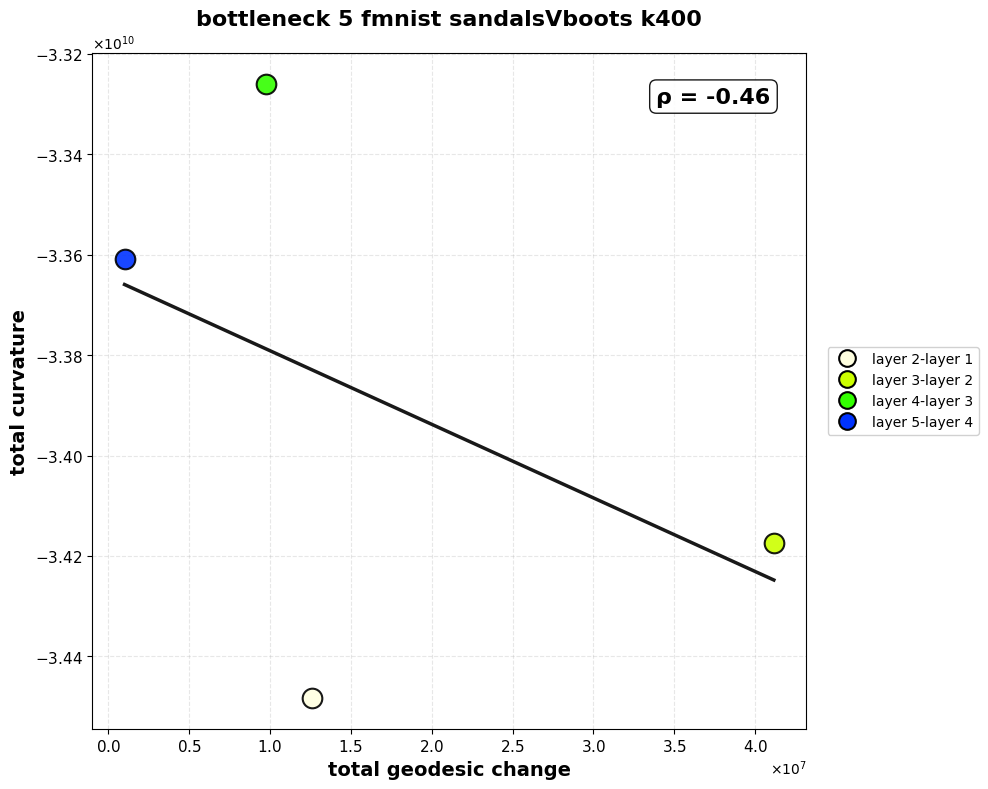

   ρ (aggregated) = -0.4630
   ρ (all points) = -0.6741
   Layer pairs: 4
   Models: 67

📊 wide 5 synthetic b k100
✅ Saved: /Users/cihan/Documents/GitHub/Ricci-Flow-Deep-Learning---Graduation-Project/visuals/wide 5 synthetic b k100.png


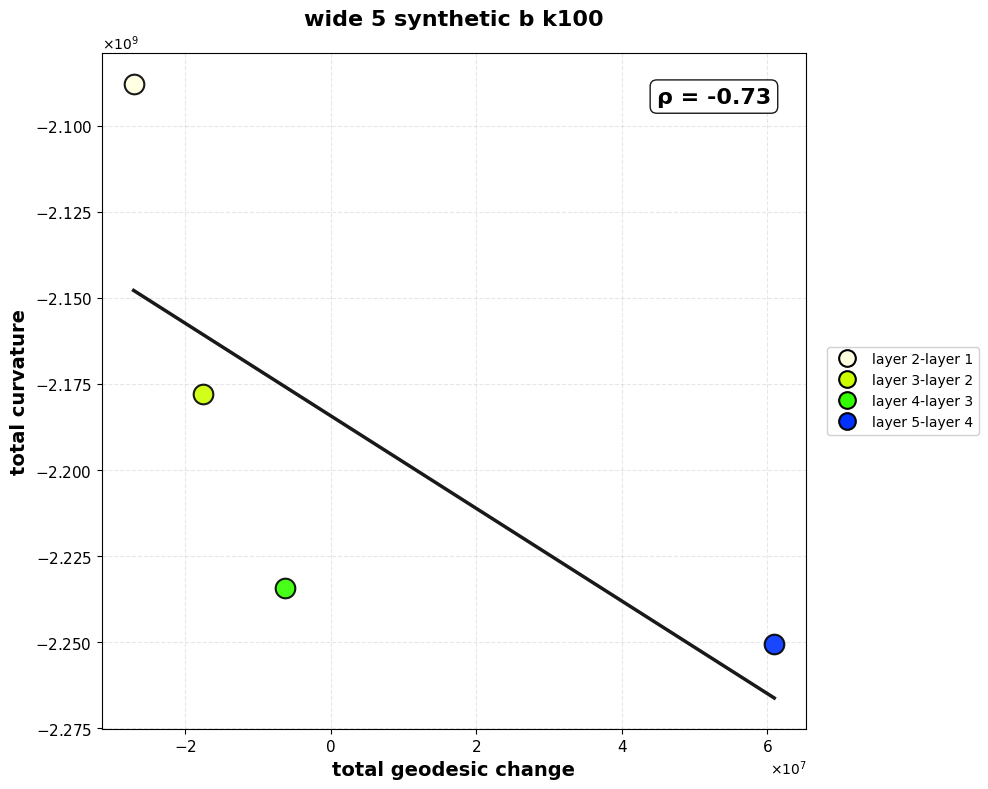

   ρ (aggregated) = -0.7294
   ρ (all points) = -0.5319
   Layer pairs: 4
   Models: 70

📊 wide 11 mnist 6v8 k500
✅ Saved: /Users/cihan/Documents/GitHub/Ricci-Flow-Deep-Learning---Graduation-Project/visuals/wide 11 mnist 6v8 k500.png


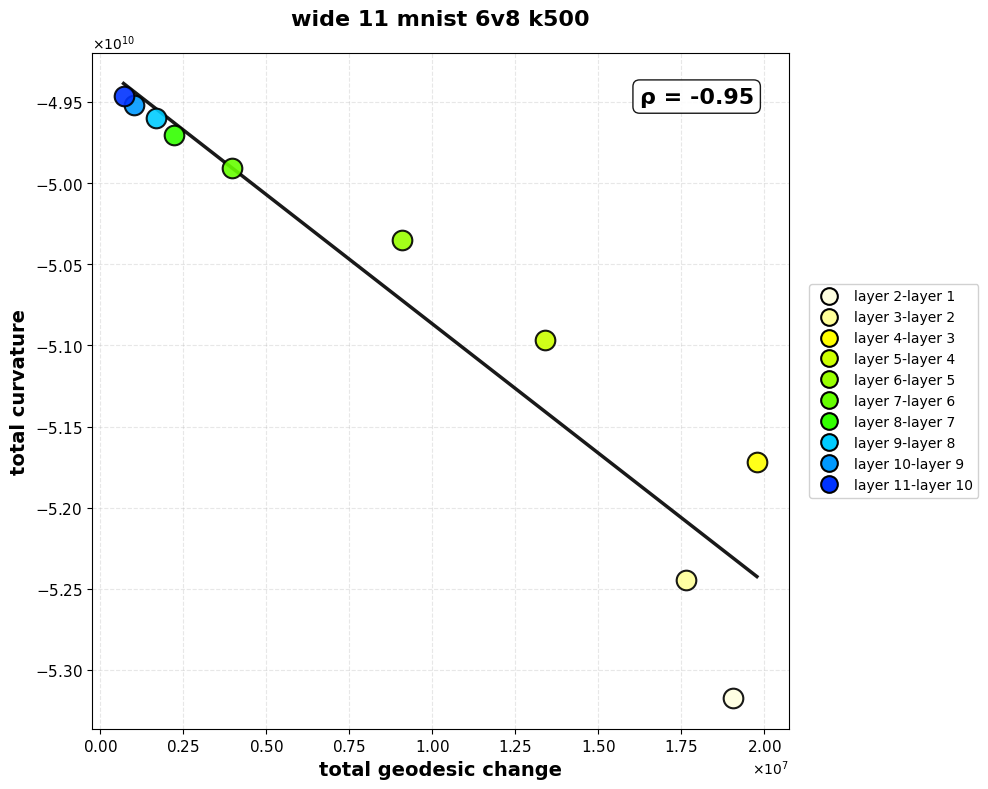

   ρ (aggregated) = -0.9452
   ρ (all points) = -0.7968
   Layer pairs: 10
   Models: 70

📊 narrow 11 synthetic c k100
✅ Saved: /Users/cihan/Documents/GitHub/Ricci-Flow-Deep-Learning---Graduation-Project/visuals/narrow 11 synthetic c k100.png


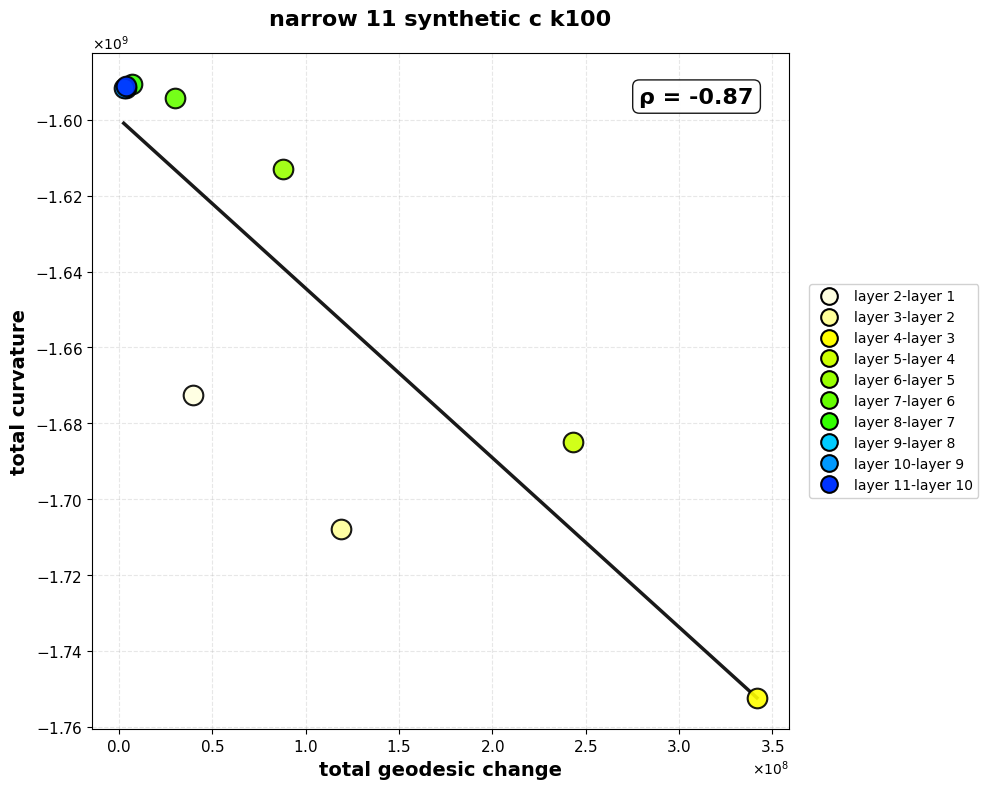

   ρ (aggregated) = -0.8669
   ρ (all points) = -0.7544
   Layer pairs: 10
   Models: 70


In [5]:
# Define the specific configurations to visualize (matching the reference images)
target_configs = [
    # (architecture, depth, dataset, k-value, display_name)
    ('bottleneck', 5, 'fmnist_sandals_vs_boots', 400, 'bottleneck 5 fmnist sandalsVboots k400'),
    ('wide', 5, 'synthetic_b', 100, 'wide 5 synthetic b k100'),
    ('wide', 11, 'mnist_6_vs_8', 500, 'wide 11 mnist 6v8 k500'),
    ('narrow', 11, 'synthetic_c', 100, 'narrow 11 synthetic c k100'),
]

results = []

for arch, depth, dataset, k, display_name in target_configs:
    print(f"\n{'='*60}")
    print(f"📊 {display_name}")
    print(f"{'='*60}")
    
    # Find matching configuration
    mask = (
        (configs_df['architecture'] == arch) & 
        (configs_df['depth'] == depth) & 
        (configs_df['dataset'] == dataset) & 
        (configs_df['k'] == k)
    )
    
    matching = configs_df[mask]
    
    if len(matching) == 0:
        print(f"⚠️ Configuration not found!")
        print(f"   Looking for: {arch}_{depth}_{dataset}/analysis_k{k}")
        continue
    
    config = matching.iloc[0]
    output_path = VISUALS_DIR / f"{display_name}.png"
    
    result = create_layer_pair_visualization(
        msc_path=config['msc_path'],
        mfr_path=config['mfr_path'],
        title=display_name,
        output_path=str(output_path),
        show_plot=True
    )
    
    result['config'] = display_name
    results.append(result)
    
    print(f"   ρ (aggregated) = {result['correlation_aggregated']:.4f}")
    print(f"   ρ (all points) = {result['r_all']:.4f}")
    print(f"   Layer pairs: {result['n_layer_pairs']}")
    print(f"   Models: {result['n_models']}")

## 📈 Summary Statistics

In [6]:
# Create summary table
if results:
    summary_df = pd.DataFrame(results)
    summary_df = summary_df[['config', 'correlation_aggregated', 'r_all', 'n_layer_pairs', 'n_models']]
    summary_df.columns = ['Configuration', 'ρ (Aggregated)', 'ρ (All Points)', 'Layer Pairs', 'Models']
    
    print("\n📊 SUMMARY OF GENERATED VISUALIZATIONS")
    print("="*80)
    display(summary_df.round(4))


📊 SUMMARY OF GENERATED VISUALIZATIONS


,Configuration,ρ (Aggregated),ρ (All Points),Layer Pairs,Models
0,bottleneck 5 fmnist sandalsVboots k400,-0.4630,-0.6741,4,67
1,wide 5 synthetic b k100,-0.7294,-0.5319,4,70
2,wide 11 mnist 6v8 k500,-0.9452,-0.7968,10,70
3,narrow 11 synthetic c k100,-0.8669,-0.7544,10,70


## 🔄 Batch Generation: All Configurations

Generate layer pair visualizations for ALL available configurations.

In [7]:
def generate_all_visualizations(save_to_analysis_dirs=True, save_to_visuals=False):
    """
    Generate layer pair visualizations for all available configurations.
    
    Parameters:
    -----------
    save_to_analysis_dirs : bool
        Save plots to respective analysis_k* directories
    save_to_visuals : bool
        Also save to the visuals/ directory with descriptive names
    """
    all_results = []
    
    print(f"📊 Generating visualizations for {len(configs_df)} configurations...")
    print("="*80)
    
    for idx, config in configs_df.iterrows():
        display_name = f"{config['architecture']} {config['depth']} {config['dataset']} k{config['k']}"
        
        # Output paths
        output_paths = []
        if save_to_analysis_dirs:
            output_paths.append(
                Path(config['analysis_dir']) / 'layer_pair_visualization.png'
            )
        if save_to_visuals:
            output_paths.append(VISUALS_DIR / f"{display_name}.png")
        
        try:
            result = create_layer_pair_visualization(
                msc_path=config['msc_path'],
                mfr_path=config['mfr_path'],
                title=display_name,
                output_path=str(output_paths[0]) if output_paths else None,
                show_plot=False
            )
            
            # Save to additional paths
            for path in output_paths[1:]:
                # Re-read and save
                import shutil
                shutil.copy(output_paths[0], path)
            
            result['config'] = display_name
            result['architecture'] = config['architecture']
            result['depth'] = config['depth']
            result['dataset'] = config['dataset']
            result['k'] = config['k']
            all_results.append(result)
            
            print(f"✅ {display_name}: ρ = {result['correlation_aggregated']:.3f}")
            
        except Exception as e:
            print(f"❌ {display_name}: {str(e)}")
    
    print("\n" + "="*80)
    print(f"✅ Generated {len(all_results)} visualizations")
    
    return pd.DataFrame(all_results)

# Uncomment to generate all visualizations:
# all_results_df = generate_all_visualizations(save_to_analysis_dirs=True, save_to_visuals=False)

## 🎛️ Interactive Explorer

Explore configurations interactively.

In [8]:
def explore_configuration(architecture, depth, dataset, k):
    """
    Interactively explore a specific configuration.
    """
    mask = (
        (configs_df['architecture'] == architecture) & 
        (configs_df['depth'] == depth) & 
        (configs_df['dataset'] == dataset) & 
        (configs_df['k'] == k)
    )
    
    matching = configs_df[mask]
    
    if len(matching) == 0:
        print(f"❌ Configuration not found: {architecture}_{depth}_{dataset}/k{k}")
        return None
    
    config = matching.iloc[0]
    display_name = f"{architecture} {depth} {dataset} k{k}"
    
    return create_layer_pair_visualization(
        msc_path=config['msc_path'],
        mfr_path=config['mfr_path'],
        title=display_name,
        show_plot=True
    )

# Example usage:
# explore_configuration('wide', 11, 'mnist_6_vs_8', 500)

## 📊 Comparison Grid: Multiple Architectures

Create a grid comparing visualizations across architectures.

In [9]:
def create_comparison_grid(dataset, k, save_path=None):
    """
    Create a 2x3 grid comparing all architectures for a given dataset and k.
    """
    architectures = [('narrow', 5), ('narrow', 11), ('wide', 5), ('wide', 11), ('bottleneck', 5), ('bottleneck', 11)]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    colors_list = [
        '#FFFFE0', '#FFFF99', '#FFFF00', '#CCFF00', '#99FF00', 
        '#66FF00', '#33FF00', '#00CCFF', '#0099FF', '#0066FF', '#0033FF'
    ]
    
    for idx, (arch, depth) in enumerate(architectures):
        ax = axes[idx]
        
        mask = (
            (configs_df['architecture'] == arch) & 
            (configs_df['depth'] == depth) & 
            (configs_df['dataset'] == dataset) & 
            (configs_df['k'] == k)
        )
        matching = configs_df[mask]
        
        if len(matching) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{arch} {depth}", fontsize=12, fontweight='bold')
            continue
        
        config = matching.iloc[0]
        
        # Read and process data
        msc = pd.read_csv(config['msc_path'])
        mfr = pd.read_csv(config['mfr_path'])
        
        mfr_shifted = mfr.copy()
        mfr_shifted['layer'] = mfr_shifted['layer'] + 1
        merged = msc.merge(mfr_shifted, on=['mod', 'layer'], suffixes=('_dg', '_fr'))
        merged_vis = merged[merged['layer'] != 1]
        
        aggregated = merged_vis.groupby('layer').agg({
            'ssr_dg': 'sum',
            'ssr_fr': 'sum'
        }).reset_index().sort_values('layer')
        
        # Correlation
        if len(aggregated) >= 2:
            corr, _ = pearsonr(aggregated['ssr_dg'], aggregated['ssr_fr'])
        else:
            corr = np.nan
        
        # Plot
        n_layers = len(aggregated)
        for i, (_, row) in enumerate(aggregated.iterrows()):
            color_idx = int((i / max(n_layers - 1, 1)) * (len(colors_list) - 1))
            ax.scatter(
                row['ssr_dg'], row['ssr_fr'],
                c=colors_list[color_idx],
                s=150,
                edgecolors='black',
                linewidth=1,
                alpha=0.9,
                zorder=3
            )
        
        # Regression line
        if len(aggregated) >= 2:
            z = np.polyfit(aggregated['ssr_dg'], aggregated['ssr_fr'], 1)
            p = np.poly1d(z)
            x_line = np.linspace(aggregated['ssr_dg'].min(), aggregated['ssr_dg'].max(), 100)
            ax.plot(x_line, p(x_line), 'k-', linewidth=2, alpha=0.8, zorder=2)
        
        ax.set_title(f"{arch} {depth}\nρ = {corr:.3f}", fontsize=12, fontweight='bold')
        ax.set_xlabel('geodesic change', fontsize=10)
        ax.set_ylabel('curvature', fontsize=10)
        ax.ticklabel_format(style='scientific', axis='both', scilimits=(0,0), useMathText=True)
        ax.grid(True, alpha=0.3, linestyle='--', zorder=1)
    
    plt.suptitle(f'Architecture Comparison: {dataset} (k={k})', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {save_path}")
    
    plt.show()

# Example: Compare all architectures for synthetic_c with k=100
# create_comparison_grid('synthetic_c', 100, save_path=VISUALS_DIR / 'architecture_comparison_synthetic_c.png')

## 🏁 Final Notes

This notebook provides:

1. **`create_layer_pair_visualization()`** - Creates individual scatter plots
2. **`generate_all_visualizations()`** - Batch generates plots for all configurations
3. **`explore_configuration()`** - Interactive exploration
4. **`create_comparison_grid()`** - Side-by-side architecture comparison

The visualizations match the style of existing plots in the `visuals/` directory.